In [68]:
import pandas as pd
import numpy as np
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import statistics

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", message="An unsupported index was provided and will be ignored when e.g. forecasting.")

In [69]:
with urllib.request.urlopen("https://hadleyserver.metoffice.gov.uk/hadcet/data/meantemp_daily_totals.txt") as response:
    data = response.read().decode('utf-8')

data = data.split("\n")

In [70]:
data_list = []

for row in data[2:-1]:
    row_list = list(filter(None, row.split(' ')))
    row_list[1] = row_list[1].rstrip('\r')
    data_list.append({'Date': row_list[0], 'Value': row_list[1]})

df = pd.DataFrame(data_list)

In [71]:
df.head()

,Date,Value
0,1772-01-01,3.2
1,1772-01-02,2.0
2,1772-01-03,2.7
3,1772-01-04,2.7
4,1772-01-05,1.5


In [72]:
df['Date'] = pd.to_datetime(df['Date'])
df['Value'] = df['Value'].astype(float)

In [73]:
df_1980_2020 = df[(df['Date'] >= '1980') & (df['Date'] < '2021')]

In [74]:
df_1980_2020

,Date,Value
75970,1980-01-01,-1.3
75971,1980-01-02,-1.8
75972,1980-01-03,2.4
75973,1980-01-04,4.5
75974,1980-01-05,4.9
...,...,...
90941,2020-12-27,4.5
90942,2020-12-28,1.0
90943,2020-12-29,0.9
90944,2020-12-30,1.0


In [75]:
df_1980_2020['Year'] = df_1980_2020['Date'].dt.year
mean_per_year = df_1980_2020.groupby('Year')['Value'].mean().reset_index()

mean_per_year.head()

,Year,Value
0,1980,9.353825
1,1981,9.188493
2,1982,9.782192
3,1983,10.054795
4,1984,9.718033


In [76]:
df_1980_2020['Day'] = df_1980_2020['Date'].dt.day
df_1980_2020['Month'] = df_1980_2020['Date'].dt.month

mean_by_day = df_1980_2020.groupby(['Month', 'Day'])['Value'].mean().reset_index()
mean_by_day.head()

,Month,Day,Value
0,1,1,4.787805
1,1,2,4.604878
2,1,3,4.390244
3,1,4,4.431707
4,1,5,4.741463


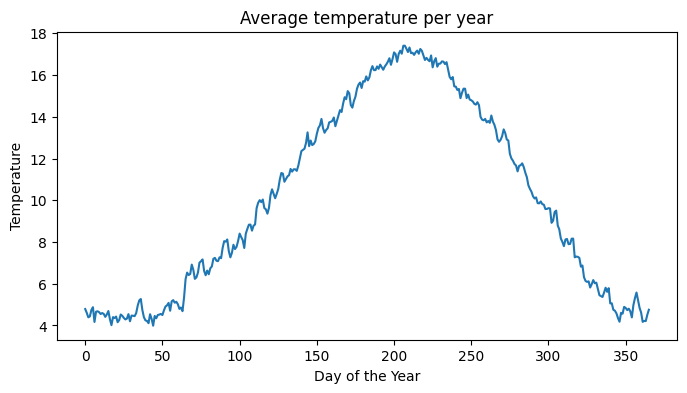

In [77]:
plt.figure(figsize=(8, 4))
plt.plot(mean_by_day['Value'])
plt.title('Average temperature per year')
plt.xlabel('Day of the Year')
plt.ylabel('Temperature')
plt.show()

In [78]:
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df = df[~((df['Month'] == 2) & (df['Day'] == 29))]
df.drop(columns=['Day', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [79]:
df['DayOfYear'] = df['Date'].dt.dayofyear
days_of_year = {day: group for day, group in df.groupby('DayOfYear')}
df.drop(columns=['DayOfYear'], inplace=True)

In [80]:
def get_window(date):
    index = df.index[df['Date'] == date][0]
    # print('Date:', str(df['Date'][index])[:10]) # , end='\r'

    start_window = str(df['Date'][index-15])[:10]
    end_window = str(df['Date'][index+15])[:10]
    ts_window = df[(df['Date'] >= start_window) & (df['Date'] <= end_window)]

    return ts_window

get_window('1984-03-01')

,Date,Value
77424,1984-02-14,1.3
77425,1984-02-15,-1.8
77426,1984-02-16,-0.8
77427,1984-02-17,1.9
77428,1984-02-18,2.7
77429,1984-02-19,0.3
77430,1984-02-20,1.3
77431,1984-02-21,3.1
77432,1984-02-22,4.7
77433,1984-02-23,3.2


In [81]:
def fill_matrix(df, year, day, w):
    """ Fill the matrix with ones for a specic day in a year given a certain window

    Args:
        df (pd.DataFrame): contains the matrix with zeros and ones
        year (int): the year for for which we want to fill the days with ones
        day (str): the day around we want to fill the days with ones
        w (int): the window indicates how many days we want to fill with ones
    """

    day_ind = df.columns.get_loc(day)

    # Loop throught the window
    for i in range(0, int(w/2)):
        ind_bef = day_ind - i
        ind_aft = day_ind + i

        # Handle if days exceeds year
        if ind_aft >= len(df.columns):
            year_aft = year + 1
            df.loc[year_aft, df.columns[ind_aft - len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_aft < len(df.columns):
          df.loc[year, df.columns[ind_aft]] = 1


        # Handle if days deceeds year
        if ind_bef < 0:
            year_bef = year - 1
            df.loc[year_bef, df.columns[ind_bef + len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_bef >= 0:
          df.loc[year, df.columns[ind_bef]] = 1


In [82]:
def get_matrix(day):
    """ Create a matrix containing zeros and ones for a specific block around a day

    Args:
        day (str): the day around we want to fill the days with ones

    Returns:
        pd.DataFrame: df containing zeros and ones for a specific date

    """

    # Create a list containing all days of a non-leap year
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

    # Make a df with days as columns and years 1979-2021 as rows
    df = pd.DataFrame(0, index=range(1979, 2022), columns=[f'{date.day}-{date.month}' for date in days_in_year])

    # State the range of years
    first_year = 1980
    last_year = 2020

    # Define window
    w = 30

    # Loop through the years and fill matrix with 1 ones around a specific date given a window w
    for year in range(first_year, last_year + 1):
        fill_matrix(df, year, day,w)

    return df

In [83]:
# Test matrix function
print(get_matrix('31-12'))
print(get_matrix('1-1'))

      1-1  2-1  3-1  4-1  5-1  6-1  7-1  8-1  9-1  10-1  ...  22-12  23-12  \
1979    0    0    0    0    0    0    0    0    0     0  ...      0      0   
1980    0    0    0    0    0    0    0    0    0     0  ...      1      1   
1981    1    1    1    1    1    1    1    1    1     1  ...      1      1   
1982    1    1    1    1    1    1    1    1    1     1  ...      1      1   
1983    1    1    1    1    1    1    1    1    1     1  ...      1      1   
1984    1    1    1    1    1    1    1    1    1     1  ...      1      1   
1985    1    1    1    1    1    1    1    1    1     1  ...      1      1   
1986    1    1    1    1    1    1    1    1    1     1  ...      1      1   
1987    1    1    1    1    1    1    1    1    1     1  ...      1      1   
1988    1    1    1    1    1    1    1    1    1     1  ...      1      1   
1989    1    1    1    1    1    1    1    1    1     1  ...      1      1   
1990    1    1    1    1    1    1    1    1    1     1  ...    

In [84]:
# phi = []
# for day in range(1, 367):
#     ts_df = pd.DataFrame()

#     for year in enumerate(days_of_year.get(day)['Date']):
#         if str(year[1])[0:10] >= '1980-01-01' and str(year[1])[0:10] <= '2020-12-31':
#             date = str(year[1])[0:10]
#             get_window(date)
#             ts_df[f'{date}'] = get_window(date)['Value'].tolist()
#     ts_mean = ts_df.mean(axis=1)
#     model = sm.tsa.SARIMAX(ts_mean, order=(1, 0, 0), trend='c')
#     result = model.fit()
#     phi.append(result.params['ar.L1'])

# print(ts_mean)
# print(phi)

In [ ]:
for day in range(1, 367):
    ts_df = pd.DataFrame()

    for year in enumerate(days_of_year.get(day)['Date']):
        if str(year[1])[0:10] >= '1980-01-01' and str(year[1])[0:10] <= '2020-12-31':
            date = str(year[1])[0:10]
            get_window(date)
            ts_df[f'{date}'] = get_window(date)['Value'].tolist()

    model = sm.tsa.VAR(ts_df)
    result = model.fit(1)

print(result.summary())

In [ ]:
# phi_list = []

# for index, date in enumerate(df['Date']):
#     if str(date)[:10] >= '1980-01-01' and str(date)[:10] <= '2020-12-31	':
#         start_window = str(df['Date'][index-15])[:10]
#         end_window = str(df['Date'][index+15])[:10]
#         print(str(df['Date'][index]), end='\r')
#         ts_window = df[(df['Date'] >= start_window) & (df['Date'] <= end_window)]
#         model = sm.tsa.SARIMAX(ts_window['Value'], order=(1, 0, 0), trend='c')
#         result = model.fit()
#         phi_list.append(result.params['ar.L1'])


In [ ]:
# df_1980_2020['Day'] = df_1980_2020['Date'].dt.day
# df_1980_2020['Month'] = df_1980_2020['Date'].dt.month
# df_1980_2020 = df_1980_2020[~((df_1980_2020['Month'] == 2) & (df_1980_2020['Day'] == 29))]
# df_1980_2020.drop(columns=['Day', 'Month'], inplace=True)
# df_1980_2020.reset_index(drop=True, inplace=True)

# df_1980_2020['Phi'] = phi_list
# df_1980_2020

In [ ]:
# df_1980_2020['Day'] = df_1980_2020['Date'].dt.day
# df_1980_2020['Month'] = df_1980_2020['Date'].dt.month

# mean_by_day = df_1980_2020.groupby(['Month', 'Day'])['Phi'].mean().reset_index()
# mean_by_day

In [ ]:
# plt.figure(figsize=(8, 4))
# plt.plot(mean_by_day['Phi'])
# plt.title('Average phi per day')
# plt.xlabel('Day of the Year')
# plt.ylabel('Temperature')
# plt.show()